## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 7 slices in the middle
* slide inference

In [18]:
idxs = range(65)
idxs

range(0, 65)

In [19]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [20]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [21]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [22]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [23]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [24]:
import segmentation_models_pytorch as smp

In [25]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [26]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp015'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 7 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [27]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [28]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [29]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [30]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [31]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


-------- exp_info -----------------


## image, mask

In [32]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    # mid = 65 // 2
    # start = mid - CFG.in_chans // 2
    # end = mid + CFG.in_chans // 2
    # idxs = range(start, end)
    idxs = [26,28,30,32,34,36,38]

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [33]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [34]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [35]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [36]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [37]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [38]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [39]:
train_dataset[0][0].shape

torch.Size([7, 224, 224])

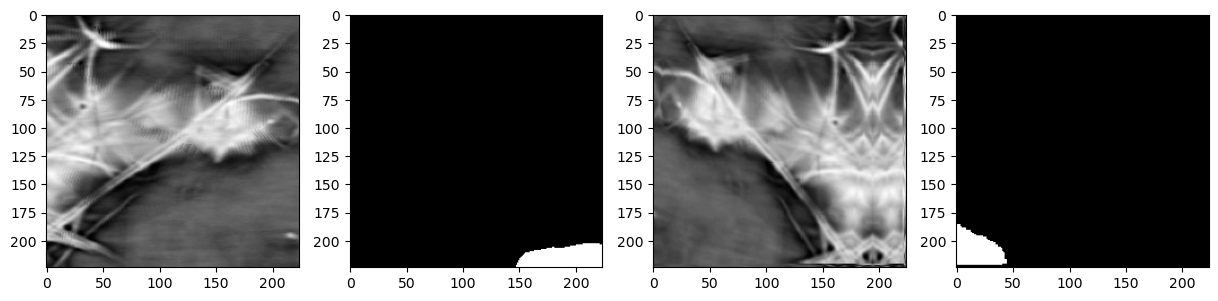

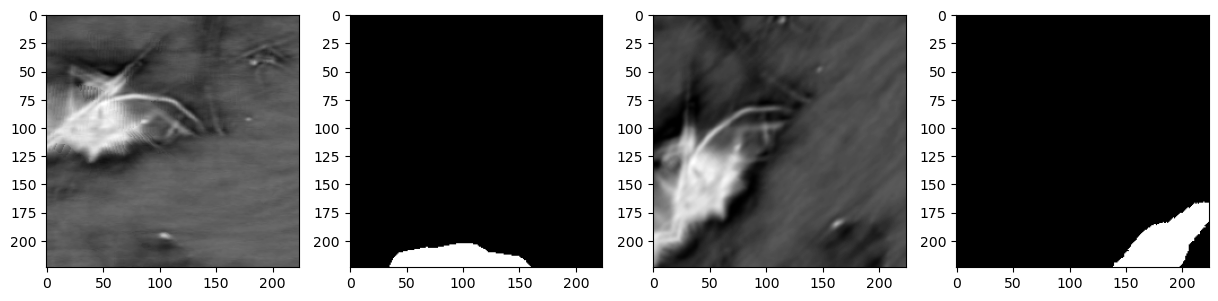

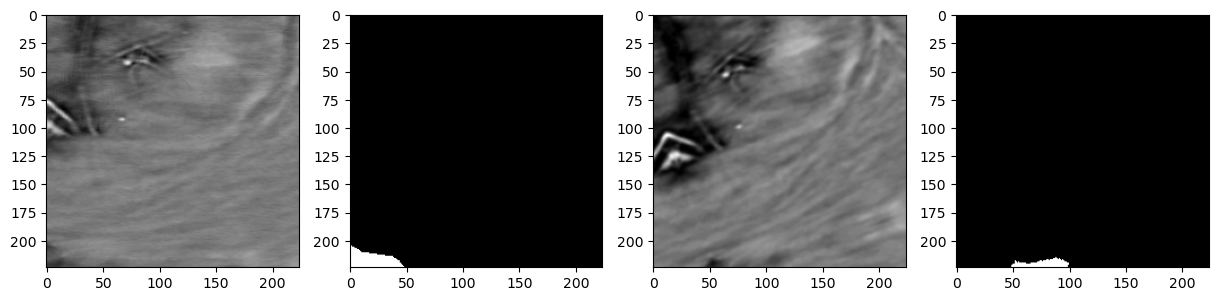

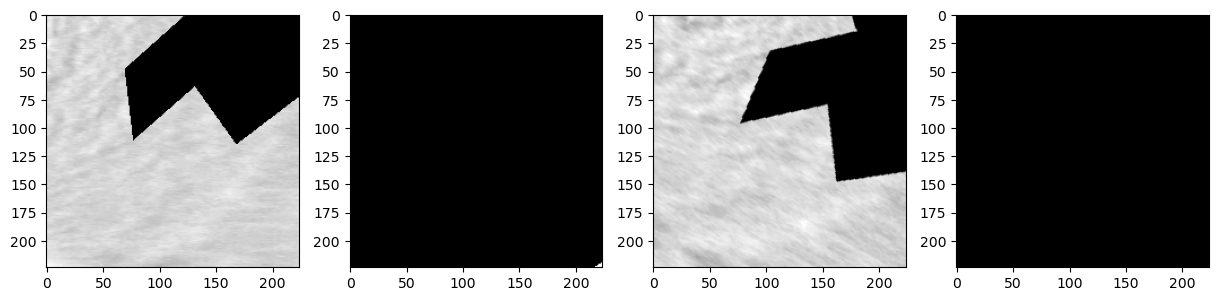

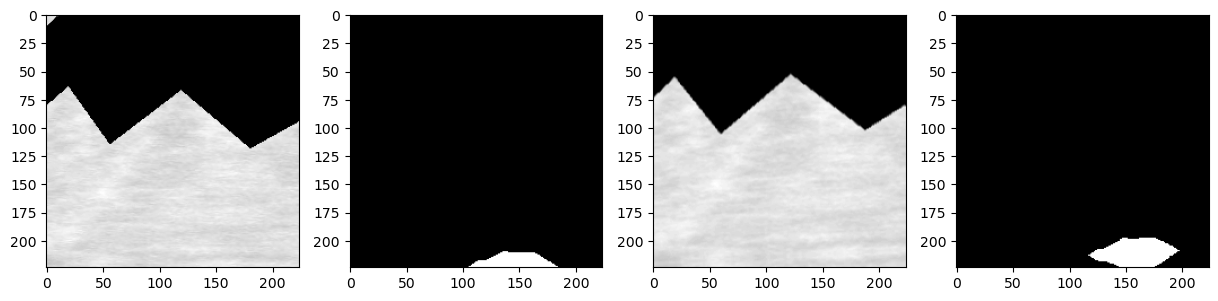

In [40]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [41]:
del plot_dataset
gc.collect()

48110

## model

In [42]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [43]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [44]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [45]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [46]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [47]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [48]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [49]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [50]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [52]:
fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1901235310680915
th: 0.15, fbeta: 0.22552358451101842
th: 0.2, fbeta: 0.2362042438173808
th: 0.25, fbeta: 0.24639749254307214
th: 0.3, fbeta: 0.2625119892514472
th: 0.35, fbeta: 0.2941063748884054
th: 0.4, fbeta: 0.340158874882346
th: 0.45, fbeta: 0.31664912388714356


best_th: 0.4, fbeta: 0.340158874882346
best_th: 0.4, fbeta: 0.340158874882346
Epoch 1 - avg_train_loss: 0.4013  avg_val_loss: 0.3333  time: 232s
Epoch 1 - avg_train_loss: 0.4013  avg_val_loss: 0.3333  time: 232s
Epoch 1 - avgScore: 0.3402
Epoch 1 - avgScore: 0.3402
Epoch 1 - Save Best Score: 0.3402 Model
Epoch 1 - Save Best Score: 0.3402 Model
Epoch 1 - Save Best Loss: 0.3333 Model
Epoch 1 - Save Best Loss: 0.3333 Model


th: 0.5, fbeta: 0.07635537741753469


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22897523683369964
th: 0.15, fbeta: 0.24630434445581043
th: 0.2, fbeta: 0.2668851623530379
th: 0.25, fbeta: 0.301607085761289
th: 0.3, fbeta: 0.353660010321529
th: 0.35, fbeta: 0.4067439668752711
th: 0.4, fbeta: 0.4392268924285161
th: 0.45, fbeta: 0.44116847516298463


best_th: 0.45, fbeta: 0.44116847516298463
best_th: 0.45, fbeta: 0.44116847516298463
Epoch 2 - avg_train_loss: 0.3070  avg_val_loss: 0.2821  time: 230s
Epoch 2 - avg_train_loss: 0.3070  avg_val_loss: 0.2821  time: 230s
Epoch 2 - avgScore: 0.4412
Epoch 2 - avgScore: 0.4412
Epoch 2 - Save Best Score: 0.4412 Model
Epoch 2 - Save Best Score: 0.4412 Model
Epoch 2 - Save Best Loss: 0.2821 Model
Epoch 2 - Save Best Loss: 0.2821 Model


th: 0.5, fbeta: 0.37788919196416026


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2996543649706235
th: 0.15, fbeta: 0.33853318278620764
th: 0.2, fbeta: 0.3715919884439442
th: 0.25, fbeta: 0.4038330485494478
th: 0.3, fbeta: 0.433978558888195
th: 0.35, fbeta: 0.45853446914270574
th: 0.4, fbeta: 0.47937779804235836
th: 0.45, fbeta: 0.49849049131296985


best_th: 0.5, fbeta: 0.5069304126271473
best_th: 0.5, fbeta: 0.5069304126271473
Epoch 3 - avg_train_loss: 0.2645  avg_val_loss: 0.2306  time: 231s
Epoch 3 - avg_train_loss: 0.2645  avg_val_loss: 0.2306  time: 231s
Epoch 3 - avgScore: 0.5069
Epoch 3 - avgScore: 0.5069
Epoch 3 - Save Best Score: 0.5069 Model
Epoch 3 - Save Best Score: 0.5069 Model
Epoch 3 - Save Best Loss: 0.2306 Model
Epoch 3 - Save Best Loss: 0.2306 Model


th: 0.5, fbeta: 0.5069304126271473


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2980464981059748
th: 0.15, fbeta: 0.3408819614438139
th: 0.2, fbeta: 0.37953192578032663
th: 0.25, fbeta: 0.4142070466497901
th: 0.3, fbeta: 0.44294226650786844
th: 0.35, fbeta: 0.46498171626140244
th: 0.4, fbeta: 0.4842290757800317
th: 0.45, fbeta: 0.4993413411165551


best_th: 0.5, fbeta: 0.506799165140642
best_th: 0.5, fbeta: 0.506799165140642
Epoch 4 - avg_train_loss: 0.2400  avg_val_loss: 0.2299  time: 230s
Epoch 4 - avg_train_loss: 0.2400  avg_val_loss: 0.2299  time: 230s
Epoch 4 - avgScore: 0.5068
Epoch 4 - avgScore: 0.5068


th: 0.5, fbeta: 0.506799165140642


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3442133261565744
th: 0.15, fbeta: 0.4052358283071473
th: 0.2, fbeta: 0.4341150977776313
th: 0.25, fbeta: 0.45698478727064484
th: 0.3, fbeta: 0.4773745828170578
th: 0.35, fbeta: 0.49142277596596073
th: 0.4, fbeta: 0.49665780928898284
th: 0.45, fbeta: 0.4964051318848557


best_th: 0.4, fbeta: 0.49665780928898284
best_th: 0.4, fbeta: 0.49665780928898284
Epoch 5 - avg_train_loss: 0.2271  avg_val_loss: 0.2322  time: 230s
Epoch 5 - avg_train_loss: 0.2271  avg_val_loss: 0.2322  time: 230s
Epoch 5 - avgScore: 0.4967
Epoch 5 - avgScore: 0.4967


th: 0.5, fbeta: 0.49101689248107444


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36466899921090806
th: 0.15, fbeta: 0.4063490409708849
th: 0.2, fbeta: 0.43689097288196754
th: 0.25, fbeta: 0.4595969269333783
th: 0.3, fbeta: 0.47839897422105426
th: 0.35, fbeta: 0.49364501649207654
th: 0.4, fbeta: 0.504298495033932
th: 0.45, fbeta: 0.512520431545042


best_th: 0.5, fbeta: 0.5162805783252995
best_th: 0.5, fbeta: 0.5162805783252995
Epoch 6 - avg_train_loss: 0.2147  avg_val_loss: 0.2385  time: 233s
Epoch 6 - avg_train_loss: 0.2147  avg_val_loss: 0.2385  time: 233s
Epoch 6 - avgScore: 0.5163
Epoch 6 - avgScore: 0.5163
Epoch 6 - Save Best Score: 0.5163 Model
Epoch 6 - Save Best Score: 0.5163 Model
Epoch 6 - Save Best Loss: 0.2385 Model
Epoch 6 - Save Best Loss: 0.2385 Model


th: 0.5, fbeta: 0.5162805783252995


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3247178688820925
th: 0.15, fbeta: 0.3628186715801054
th: 0.2, fbeta: 0.39615290064827297
th: 0.25, fbeta: 0.42438999582912773
th: 0.3, fbeta: 0.4510566321670017
th: 0.35, fbeta: 0.4720595435216096
th: 0.4, fbeta: 0.4890247987590639
th: 0.45, fbeta: 0.5048349471789907


best_th: 0.5, fbeta: 0.5137251692986742
best_th: 0.5, fbeta: 0.5137251692986742
Epoch 7 - avg_train_loss: 0.2025  avg_val_loss: 0.2335  time: 232s
Epoch 7 - avg_train_loss: 0.2025  avg_val_loss: 0.2335  time: 232s
Epoch 7 - avgScore: 0.5137
Epoch 7 - avgScore: 0.5137


th: 0.5, fbeta: 0.5137251692986742


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3788272004849458
th: 0.15, fbeta: 0.42398745237857954
th: 0.2, fbeta: 0.4534218555693524
th: 0.25, fbeta: 0.4719422078259586
th: 0.3, fbeta: 0.48126110634752894
th: 0.35, fbeta: 0.48568765538887126
th: 0.4, fbeta: 0.48273357907488157
th: 0.45, fbeta: 0.47615160989193356


best_th: 0.35, fbeta: 0.48568765538887126
best_th: 0.35, fbeta: 0.48568765538887126
Epoch 8 - avg_train_loss: 0.1874  avg_val_loss: 0.2489  time: 231s
Epoch 8 - avg_train_loss: 0.1874  avg_val_loss: 0.2489  time: 231s
Epoch 8 - avgScore: 0.4857
Epoch 8 - avgScore: 0.4857


th: 0.5, fbeta: 0.4678704335110041


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3811412344334605
th: 0.15, fbeta: 0.41697784554758094
th: 0.2, fbeta: 0.44374049387794134
th: 0.25, fbeta: 0.46193712912254226
th: 0.3, fbeta: 0.475292164503299
th: 0.35, fbeta: 0.4867492823787302
th: 0.4, fbeta: 0.49566665442750696
th: 0.45, fbeta: 0.4972328612888589


best_th: 0.5, fbeta: 0.4976655685597397
best_th: 0.5, fbeta: 0.4976655685597397
Epoch 9 - avg_train_loss: 0.1760  avg_val_loss: 0.2608  time: 231s
Epoch 9 - avg_train_loss: 0.1760  avg_val_loss: 0.2608  time: 231s
Epoch 9 - avgScore: 0.4977
Epoch 9 - avgScore: 0.4977


th: 0.5, fbeta: 0.4976655685597397


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38224400936276337
th: 0.15, fbeta: 0.40110654618947567
th: 0.2, fbeta: 0.4144549221703423
th: 0.25, fbeta: 0.42841669858194936
th: 0.3, fbeta: 0.43711003439998464
th: 0.35, fbeta: 0.4410239012335836
th: 0.4, fbeta: 0.4406201653028878
th: 0.45, fbeta: 0.44096662793631597


best_th: 0.35, fbeta: 0.4410239012335836
best_th: 0.35, fbeta: 0.4410239012335836
Epoch 10 - avg_train_loss: 0.1688  avg_val_loss: 0.2944  time: 230s
Epoch 10 - avg_train_loss: 0.1688  avg_val_loss: 0.2944  time: 230s
Epoch 10 - avgScore: 0.4410
Epoch 10 - avgScore: 0.4410


th: 0.5, fbeta: 0.43581267364032245


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39787910040764735
th: 0.15, fbeta: 0.4277168599670882
th: 0.2, fbeta: 0.44931750969966006
th: 0.25, fbeta: 0.4634032324159723
th: 0.3, fbeta: 0.4754480983944621
th: 0.35, fbeta: 0.48276183914853216
th: 0.4, fbeta: 0.48595083310581727
th: 0.45, fbeta: 0.48643259580681886


best_th: 0.45, fbeta: 0.48643259580681886
best_th: 0.45, fbeta: 0.48643259580681886
Epoch 11 - avg_train_loss: 0.1593  avg_val_loss: 0.2723  time: 232s
Epoch 11 - avg_train_loss: 0.1593  avg_val_loss: 0.2723  time: 232s
Epoch 11 - avgScore: 0.4864
Epoch 11 - avgScore: 0.4864


th: 0.5, fbeta: 0.4863844933818468


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4324946693644117
th: 0.15, fbeta: 0.46114787352112396
th: 0.2, fbeta: 0.4797181219570651
th: 0.25, fbeta: 0.49285351626128243
th: 0.3, fbeta: 0.5047541843554665
th: 0.35, fbeta: 0.511052664056279
th: 0.4, fbeta: 0.512088885267045
th: 0.45, fbeta: 0.5080893625267022


best_th: 0.4, fbeta: 0.512088885267045
best_th: 0.4, fbeta: 0.512088885267045
Epoch 12 - avg_train_loss: 0.1495  avg_val_loss: 0.2816  time: 231s
Epoch 12 - avg_train_loss: 0.1495  avg_val_loss: 0.2816  time: 231s
Epoch 12 - avgScore: 0.5121
Epoch 12 - avgScore: 0.5121


th: 0.5, fbeta: 0.49911241340502566


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42188826945907043
th: 0.15, fbeta: 0.45305154030931016
th: 0.2, fbeta: 0.474355735632295
th: 0.25, fbeta: 0.48767459333505947
th: 0.3, fbeta: 0.4944805507527151
th: 0.35, fbeta: 0.49938852090265445
th: 0.4, fbeta: 0.5032721899842415
th: 0.45, fbeta: 0.5059398462501271


best_th: 0.45, fbeta: 0.5059398462501271
best_th: 0.45, fbeta: 0.5059398462501271
Epoch 13 - avg_train_loss: 0.1370  avg_val_loss: 0.3078  time: 231s
Epoch 13 - avg_train_loss: 0.1370  avg_val_loss: 0.3078  time: 231s
Epoch 13 - avgScore: 0.5059
Epoch 13 - avgScore: 0.5059


th: 0.5, fbeta: 0.5037023502900223


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39935280674365603
th: 0.15, fbeta: 0.43238949494415185
th: 0.2, fbeta: 0.45517000339331826
th: 0.25, fbeta: 0.4706933775616661
th: 0.3, fbeta: 0.47971819828968854
th: 0.35, fbeta: 0.48571404607526847
th: 0.4, fbeta: 0.48799730911966993
th: 0.45, fbeta: 0.48694073960125445


best_th: 0.4, fbeta: 0.48799730911966993
best_th: 0.4, fbeta: 0.48799730911966993
Epoch 14 - avg_train_loss: 0.1302  avg_val_loss: 0.3015  time: 233s
Epoch 14 - avg_train_loss: 0.1302  avg_val_loss: 0.3015  time: 233s
Epoch 14 - avgScore: 0.4880
Epoch 14 - avgScore: 0.4880


th: 0.5, fbeta: 0.48280656089384616


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37877905610481544
th: 0.15, fbeta: 0.4034809258188723
th: 0.2, fbeta: 0.42468978660133844
th: 0.25, fbeta: 0.4438149372333809
th: 0.3, fbeta: 0.459018384504377
th: 0.35, fbeta: 0.470001580103297
th: 0.4, fbeta: 0.4757504307843097
th: 0.45, fbeta: 0.4801125781067953


best_th: 0.5, fbeta: 0.48359824481901487
best_th: 0.5, fbeta: 0.48359824481901487
Epoch 15 - avg_train_loss: 0.1226  avg_val_loss: 0.3121  time: 232s
Epoch 15 - avg_train_loss: 0.1226  avg_val_loss: 0.3121  time: 232s
Epoch 15 - avgScore: 0.4836
Epoch 15 - avgScore: 0.4836


th: 0.5, fbeta: 0.48359824481901487


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4047328336144384
th: 0.15, fbeta: 0.43007154979926765
th: 0.2, fbeta: 0.4477610956750568
th: 0.25, fbeta: 0.46099455596436517
th: 0.3, fbeta: 0.4709691051982338
th: 0.35, fbeta: 0.48027202002111985
th: 0.4, fbeta: 0.48529317111644005
th: 0.45, fbeta: 0.48885363605887555


best_th: 0.45, fbeta: 0.48885363605887555
best_th: 0.45, fbeta: 0.48885363605887555
Epoch 16 - avg_train_loss: 0.1147  avg_val_loss: 0.3177  time: 231s
Epoch 16 - avg_train_loss: 0.1147  avg_val_loss: 0.3177  time: 231s
Epoch 16 - avgScore: 0.4889
Epoch 16 - avgScore: 0.4889


th: 0.5, fbeta: 0.4858649972700713


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4148252895526591
th: 0.15, fbeta: 0.44962007412429994
th: 0.2, fbeta: 0.47477393672972523
th: 0.25, fbeta: 0.49100256357036065
th: 0.3, fbeta: 0.49478399714702626
th: 0.35, fbeta: 0.4983595129207017
th: 0.4, fbeta: 0.49951412552513813
th: 0.45, fbeta: 0.4951196799137706


best_th: 0.4, fbeta: 0.49951412552513813
best_th: 0.4, fbeta: 0.49951412552513813
Epoch 17 - avg_train_loss: 0.1093  avg_val_loss: 0.3287  time: 232s
Epoch 17 - avg_train_loss: 0.1093  avg_val_loss: 0.3287  time: 232s
Epoch 17 - avgScore: 0.4995
Epoch 17 - avgScore: 0.4995


th: 0.5, fbeta: 0.4853281727867913


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3869875080365918
th: 0.15, fbeta: 0.41585289443283735
th: 0.2, fbeta: 0.4375880306094684
th: 0.25, fbeta: 0.4546823051213143
th: 0.3, fbeta: 0.4677326297605333
th: 0.35, fbeta: 0.477706830320405
th: 0.4, fbeta: 0.48345122878352603
th: 0.45, fbeta: 0.4837948030196068


best_th: 0.45, fbeta: 0.4837948030196068
best_th: 0.45, fbeta: 0.4837948030196068
Epoch 18 - avg_train_loss: 0.1025  avg_val_loss: 0.3302  time: 231s
Epoch 18 - avg_train_loss: 0.1025  avg_val_loss: 0.3302  time: 231s
Epoch 18 - avgScore: 0.4838
Epoch 18 - avgScore: 0.4838


th: 0.5, fbeta: 0.481470186429146


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4178620189231743
th: 0.15, fbeta: 0.4489556530168216
th: 0.2, fbeta: 0.4716450539451141
th: 0.25, fbeta: 0.4867485496925189
th: 0.3, fbeta: 0.497551147623115
th: 0.35, fbeta: 0.5032315134067962
th: 0.4, fbeta: 0.5038035229845154
th: 0.45, fbeta: 0.5044520052204041


best_th: 0.45, fbeta: 0.5044520052204041
best_th: 0.45, fbeta: 0.5044520052204041
Epoch 19 - avg_train_loss: 0.0949  avg_val_loss: 0.3580  time: 230s
Epoch 19 - avg_train_loss: 0.0949  avg_val_loss: 0.3580  time: 230s
Epoch 19 - avgScore: 0.5045
Epoch 19 - avgScore: 0.5045


th: 0.5, fbeta: 0.5039013378336485


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38013333703654395
th: 0.15, fbeta: 0.4026367486993818
th: 0.2, fbeta: 0.4206190374827115
th: 0.25, fbeta: 0.43650929162789726
th: 0.3, fbeta: 0.45055469973406104
th: 0.35, fbeta: 0.4623117806977291
th: 0.4, fbeta: 0.4708955369300441
th: 0.45, fbeta: 0.4743086892122949


best_th: 0.45, fbeta: 0.4743086892122949
best_th: 0.45, fbeta: 0.4743086892122949
Epoch 20 - avg_train_loss: 0.0911  avg_val_loss: 0.3633  time: 230s
Epoch 20 - avg_train_loss: 0.0911  avg_val_loss: 0.3633  time: 230s
Epoch 20 - avgScore: 0.4743
Epoch 20 - avgScore: 0.4743


th: 0.5, fbeta: 0.47350023740734976


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3998766257144968
th: 0.15, fbeta: 0.42413133595164626
th: 0.2, fbeta: 0.4424515227849444
th: 0.25, fbeta: 0.45836830644959015
th: 0.3, fbeta: 0.47248488576402686
th: 0.35, fbeta: 0.4845116490522078
th: 0.4, fbeta: 0.4920224162996437
th: 0.45, fbeta: 0.49631772007328306


best_th: 0.5, fbeta: 0.49788129142573595
best_th: 0.5, fbeta: 0.49788129142573595
Epoch 21 - avg_train_loss: 0.0863  avg_val_loss: 0.3670  time: 229s
Epoch 21 - avg_train_loss: 0.0863  avg_val_loss: 0.3670  time: 229s
Epoch 21 - avgScore: 0.4979
Epoch 21 - avgScore: 0.4979


th: 0.5, fbeta: 0.49788129142573595


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40205012755564457
th: 0.15, fbeta: 0.4265557548768918
th: 0.2, fbeta: 0.4451500201376904
th: 0.25, fbeta: 0.46073975514024207
th: 0.3, fbeta: 0.4735017494710538
th: 0.35, fbeta: 0.48386964000375926
th: 0.4, fbeta: 0.4900086506310635
th: 0.45, fbeta: 0.4930114882029631


best_th: 0.45, fbeta: 0.4930114882029631
best_th: 0.45, fbeta: 0.4930114882029631
Epoch 22 - avg_train_loss: 0.0798  avg_val_loss: 0.3932  time: 231s
Epoch 22 - avg_train_loss: 0.0798  avg_val_loss: 0.3932  time: 231s
Epoch 22 - avgScore: 0.4930
Epoch 22 - avgScore: 0.4930


th: 0.5, fbeta: 0.49296352593804565


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3936896425777503
th: 0.15, fbeta: 0.41676169540885416
th: 0.2, fbeta: 0.4357924290290535
th: 0.25, fbeta: 0.44949943474230225
th: 0.3, fbeta: 0.45943351927357595
th: 0.35, fbeta: 0.4666605136137183
th: 0.4, fbeta: 0.4732465140855005
th: 0.45, fbeta: 0.4761328512041381


best_th: 0.45, fbeta: 0.4761328512041381
best_th: 0.45, fbeta: 0.4761328512041381
Epoch 23 - avg_train_loss: 0.0770  avg_val_loss: 0.3988  time: 230s
Epoch 23 - avg_train_loss: 0.0770  avg_val_loss: 0.3988  time: 230s
Epoch 23 - avgScore: 0.4761
Epoch 23 - avgScore: 0.4761


th: 0.5, fbeta: 0.47484894379267845


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3946418361839979
th: 0.15, fbeta: 0.4138007380321885
th: 0.2, fbeta: 0.4303502528403456
th: 0.25, fbeta: 0.4458646321798922
th: 0.3, fbeta: 0.4574453814704781
th: 0.35, fbeta: 0.4674630885371632
th: 0.4, fbeta: 0.47508126356453173
th: 0.45, fbeta: 0.47989063513929503


best_th: 0.45, fbeta: 0.47989063513929503
best_th: 0.45, fbeta: 0.47989063513929503
Epoch 24 - avg_train_loss: 0.0746  avg_val_loss: 0.3883  time: 230s
Epoch 24 - avg_train_loss: 0.0746  avg_val_loss: 0.3883  time: 230s
Epoch 24 - avgScore: 0.4799
Epoch 24 - avgScore: 0.4799


th: 0.5, fbeta: 0.47891293892608844


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4028792215436736
th: 0.15, fbeta: 0.42623120374451273
th: 0.2, fbeta: 0.4465770653513531
th: 0.25, fbeta: 0.4618616461633424
th: 0.3, fbeta: 0.47200679184982114
th: 0.35, fbeta: 0.4811399806606609
th: 0.4, fbeta: 0.4886342491552781
th: 0.45, fbeta: 0.4942365863792861


best_th: 0.5, fbeta: 0.4943019055127393
best_th: 0.5, fbeta: 0.4943019055127393
Epoch 25 - avg_train_loss: 0.0720  avg_val_loss: 0.3885  time: 231s
Epoch 25 - avg_train_loss: 0.0720  avg_val_loss: 0.3885  time: 231s
Epoch 25 - avgScore: 0.4943
Epoch 25 - avgScore: 0.4943


th: 0.5, fbeta: 0.4943019055127393


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40802747053289184
th: 0.15, fbeta: 0.42943298777069433
th: 0.2, fbeta: 0.44775295706238194
th: 0.25, fbeta: 0.4625376604285531
th: 0.3, fbeta: 0.47306475714415924
th: 0.35, fbeta: 0.48050739784573354
th: 0.4, fbeta: 0.4863464146246671
th: 0.45, fbeta: 0.49016576213540364


best_th: 0.5, fbeta: 0.49060812488661865
best_th: 0.5, fbeta: 0.49060812488661865
Epoch 26 - avg_train_loss: 0.0692  avg_val_loss: 0.4016  time: 231s
Epoch 26 - avg_train_loss: 0.0692  avg_val_loss: 0.4016  time: 231s
Epoch 26 - avgScore: 0.4906
Epoch 26 - avgScore: 0.4906


th: 0.5, fbeta: 0.49060812488661865


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4078823193269356
th: 0.15, fbeta: 0.4285214809279185
th: 0.2, fbeta: 0.44560833875831024
th: 0.25, fbeta: 0.45959978268565815
th: 0.3, fbeta: 0.4671584578285956
th: 0.35, fbeta: 0.4718133232869024
th: 0.4, fbeta: 0.47714088016485084
th: 0.45, fbeta: 0.482065865039919


best_th: 0.45, fbeta: 0.482065865039919
best_th: 0.45, fbeta: 0.482065865039919
Epoch 27 - avg_train_loss: 0.0678  avg_val_loss: 0.4179  time: 229s
Epoch 27 - avg_train_loss: 0.0678  avg_val_loss: 0.4179  time: 229s
Epoch 27 - avgScore: 0.4821
Epoch 27 - avgScore: 0.4821


th: 0.5, fbeta: 0.4817750477586122


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4081644346802592
th: 0.15, fbeta: 0.4297940009609543
th: 0.2, fbeta: 0.4485262975971324
th: 0.25, fbeta: 0.46247605674343667
th: 0.3, fbeta: 0.4698341029003022
th: 0.35, fbeta: 0.47465876372756244
th: 0.4, fbeta: 0.47799288393773
th: 0.45, fbeta: 0.48100177351428175


best_th: 0.45, fbeta: 0.48100177351428175
best_th: 0.45, fbeta: 0.48100177351428175
Epoch 28 - avg_train_loss: 0.0661  avg_val_loss: 0.4367  time: 231s
Epoch 28 - avg_train_loss: 0.0661  avg_val_loss: 0.4367  time: 231s
Epoch 28 - avgScore: 0.4810
Epoch 28 - avgScore: 0.4810


th: 0.5, fbeta: 0.4794150814997223


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42129882501465926
th: 0.15, fbeta: 0.44128053227862774
th: 0.2, fbeta: 0.45599095244526455
th: 0.25, fbeta: 0.4685075311917451
th: 0.3, fbeta: 0.47595396312650695
th: 0.35, fbeta: 0.48170131062136035
th: 0.4, fbeta: 0.4858461370019371
th: 0.45, fbeta: 0.48898782641929356


best_th: 0.45, fbeta: 0.48898782641929356
best_th: 0.45, fbeta: 0.48898782641929356
Epoch 29 - avg_train_loss: 0.0640  avg_val_loss: 0.4367  time: 230s
Epoch 29 - avg_train_loss: 0.0640  avg_val_loss: 0.4367  time: 230s
Epoch 29 - avgScore: 0.4890
Epoch 29 - avgScore: 0.4890


th: 0.5, fbeta: 0.48685987344638704


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41451093698971603
th: 0.15, fbeta: 0.43567602427980534
th: 0.2, fbeta: 0.4539755416909537
th: 0.25, fbeta: 0.467930780185153
th: 0.3, fbeta: 0.4750785655667785
th: 0.35, fbeta: 0.47989387588151783
th: 0.4, fbeta: 0.483897693322065
th: 0.45, fbeta: 0.48797806935520366


best_th: 0.45, fbeta: 0.48797806935520366
best_th: 0.45, fbeta: 0.48797806935520366
Epoch 30 - avg_train_loss: 0.0644  avg_val_loss: 0.4286  time: 230s
Epoch 30 - avg_train_loss: 0.0644  avg_val_loss: 0.4286  time: 230s
Epoch 30 - avgScore: 0.4880
Epoch 30 - avgScore: 0.4880


th: 0.5, fbeta: 0.4861267299875117


In [53]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [54]:
mask_pred = check_point['preds']

In [55]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.36466899921090806
th: 0.15, fbeta: 0.4063490409708849
th: 0.2, fbeta: 0.43689097288196754
th: 0.25, fbeta: 0.4595969269333783
th: 0.3, fbeta: 0.47839897422105426
th: 0.35, fbeta: 0.49364501649207654
th: 0.4, fbeta: 0.504298495033932
th: 0.45, fbeta: 0.512520431545042


best_th: 0.5, fbeta: 0.5162805783252995
best_th: 0.5, fbeta: 0.5162805783252995


th: 0.5, fbeta: 0.5162805783252995


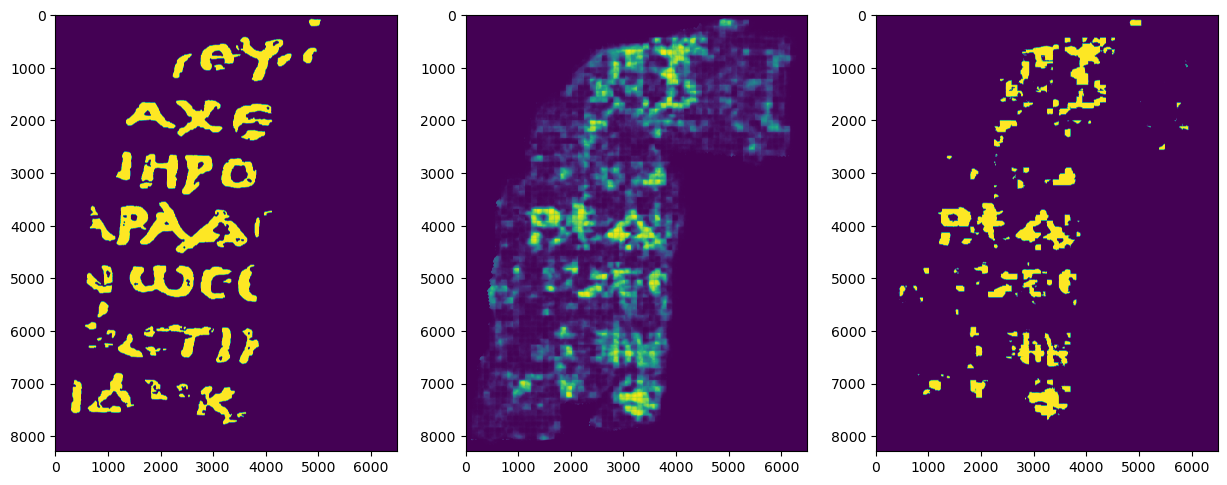

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([35332406.,  5634415.,  2661515.,  1796585.,  1344666.,  1035141.,
          839193.,   692174.,   599993.,   571203.,   526638.,   451102.,
          399375.,   372807.,   380730.,   329896.,   311940.,   272143.,
          212117.,    74809.]),
 array([1.25733320e-05, 4.74205262e-02, 9.48284790e-02, 1.42236432e-01,
        1.89644385e-01, 2.37052338e-01, 2.84460290e-01, 3.31868243e-01,
        3.79276196e-01, 4.26684149e-01, 4.74092102e-01, 5.21500055e-01,
        5.68908008e-01, 6.16315960e-01, 6.63723913e-01, 7.11131866e-01,
        7.58539819e-01, 8.05947772e-01, 8.53355725e-01, 9.00763678e-01,
        9.48171631e-01]),
 <BarContainer object of 20 artists>)

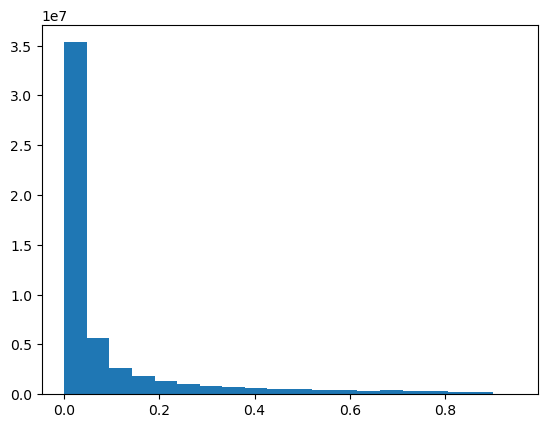

In [57]:
plt.hist(mask_pred.flatten(), bins=20)

In [58]:
# GPU VRAM 5.2GB/16.0GB A4000